<a href="https://colab.research.google.com/github/yexf308/AdvancedMachineLearning/blob/main/Manifold_Learning_LLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

refer to the [notes](https://cs.nyu.edu/~roweis/lle/papers/lleintro.pdf).

In [1]:
%pylab inline 
from IPython.display import Image
import numpy.linalg as LA
import scipy as sp


Populating the interactive namespace from numpy and matplotlib


$\def\m#1{\mathbf{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
# Locally Linear Embedding
## Construct the weight
The LLE algorithm assumes each data point and its neighbors to lie on or close to a locally linear patch of the manifold, if there is sufficient data (such that the manifold is well-sampled). (Think about the definition of manifold.)


Suppose the data lie on or near a smooth nonlinear manifold, to a good approximation, there exists a linear mapping—consisting
of a translation, rotation, and rescaling—that maps the **high dimensional coordinates** of each neighborhood to **global internal coordinates** on the manifold. 


We can characterize the local geometry of these patches by linear coefficients that reconstruct each data point from its neighbor (which can be from kNN or $\epsilon$-ball). 


Reconstruction errors are then measured by the cost function: 
\begin{align}
\hat{\m{W}} = \arg\min_{\m{W}}\sum_{i=1}^N \|\m{x}^{(i)}-\sum_{j=1}^Nw_{ij}\m{x}^{(j)}\|_2^2
\end{align}
subject to $\sum_{j=1}^N w_{ij}=1$ and $w_{ij}=0$ if $\m{x}^{(j)}\notin \text{nbr}(\m{x}^{(i)})$. 
Note that we need the sum-to-one constraint on the weights enforces the invariance to **translations**. The cost function itself is invariant to **rotation and rescaling**. 

The weight matrix $w_{ij}$ 
summarize the contribution of the $j$-th data point to
the $i$-th reconstruction. The LLE computes the **barycentric coordinates** of a point $\m{x}^{(i)}$ based on its neighbors. It 
reflect intrinsic geometric properties of the data that are invariant to exactly such transformations.

The optimal weights $\m{W}$ subject
to these constraints are found by solving a least squares problem. 


In [2]:
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/LLE.png?raw=true', width=600))

##  Constrained Least Squares Problem

The constrained weights that best reconstruct each data point from its neighbors can be computed in close form. Consider a particular data $\m{x}$ with $K$-nearest neighbours $\eta^{(j)}$ and the weight $w_j$ sum to be 1.  We can write the
reconstruction error as 
\begin{align}
E &= \|\m{x}-\sum_{j=1}^K w_j \eta^{(j)}\|_2^2  \\
&=\|\sum_{j=1}^K w_j(\m{x}-\eta^{(j)})\|_2^2 \\
& = \sum_{j,k=1}^K w_jw_k C_{jk}
\end{align}
where the local covariance matrix $C$ is 
$$C_{jk}=(\m{x}-\eta^{(j)})^\top (\m{x}-\eta^{(k)}) $$
By construction,
the local covariance matrix is SPD. 

- This error can be minimized in closed form, using a Lagrange multiplier to enforce
the constraint that $\sum_{j}w_j=1$. In terms of the inverse local covariance matrix $C$, the
optimal weights are given by 
$$ w_j = \frac{\sum_k (C^{-1})_{jk}}{\sum_{lm} (C^{-1})_{lm}}$$

- In practice, a more efficient way to minimize the error without inverting the matrix is simply to solve the linear system of equations, $\sum_{j}C_{jk}w_k=1$ and and then to rescale
the weights so that they sum to one (which yields the same result). 

- Remark: if the covariance matrix is singular or nearly singular, it can be conditioned (before solving the system) by
adding a small multiple of the identity matrix. 
$$C_{jk} \leftarrow C_{jk} +\frac{\Delta^2}{K}\delta_{jk} $$
where $\Delta^2$ is small compared to the trace of $C$. 

## low-dimensional embeddings
LLE constructs a neighborhood preserving mapping based on the above idea. In the final step of the algorithm, each high dimensional observation $\m{x}^{(i)}$ is mapped to a
low dimensional vector $\m{z}^{(i)}$ representing global internal coordinates on the manifold. We can solve for the low-dimensional embeddings for each point by solving
\begin{align}
\hat{\m{Z}}= \arg\min_{\m{Z}}\sum_{i=1}^N\|\m{z}^{(i)}- \sum_{j=1}^N \hat{w}_{ij}\m{z}^{(j)}\|_2^2
\end{align}
where $\hat w_{ij}=0$ if $j$ is not the nearest neighbor of $i$. 
We can rewrite this loss as
\begin{align}
L(\m{Z}) =\|\m{Z}-\m{W}\m{Z}\|_2^2 =\m{Z}^\top (\m{I}-\m{W})^\top (\m{I}-\m{W}) \m{Z}
\end{align}
Note $\m{W}$ is in general **sparse**. 

- Define $\m{M}$ as the $\m{M}=(\m{I}-\m{W})^\top (\m{I}-\m{W})$. .
The optimal embedding—up to a global rotation of the embedding space—is found
by computing the bottom $d+1$ eigenvectors of $\m{M}$. 

- The bottom eigenvector of this matrix, which we
discard, is the unit vector with all equal components; it represents a free translation
mode of eigenvalue 0. 
Discarding this eigenvector enforces the constraint that
the embeddings have zero mean, since the components of other eigenvectors must
sum to zero, by virtue of orthogonality. The remaining $d$
eigenvectors form the $d$
embedding coordinates found by LLE. 

- The bottom $d+1$ eigenvector of $\m{M}$ can be found without performing the full matrix
diagonalization since the matrix $\m{M}$ is sparse. In particular, the left multiplication of $\m{M}$ is 
\begin{align}
\m{M}v = (v-\m{W}v)-\m{W}^\top(v-\m{W}v)
\end{align}
requiring just one multiplication by $\m{W}$ and 
 one multiplication by $\m{W}^\top$. both of
which are extremely sparse. Thus, the matrix $\m{M}$ never needs to be explicitly created or stored. 

- Another advantage is if more dimensions are added to the embedding space,
the existing ones do not change, so that LLE does not have to be rerun to compute higher dimensional embeddings.  The storage requirements of LLE are limited by
the weight matrix which is size $N\times K$.

## Locally Linear Embedding Algorithm
**Input:** data matrix $\m{X}$, embedding dimension $d$.

**Output:** A $d$-dimensional representation of the input data ($\m{Z}\in\mb{R}^{N\times d}$). 

- Compute the neighbors of each data point, $\m{x}^{(i)}$ (kNN or $\epsilon$-ball). 

- Compute the weights $w_{ij}$ that best reconstruct each data point $\m{x}^{(i)}$ 
from its neighbors, minimizing the cost by constrained linear fits.

- Compute the vectors $\m{z}^{(i)}$ best reconstructed by the weights $w_{ij}$ minimizing
the quadratic form  by its bottom nonzero $d$ eigenvectors. 

### Complexities of LLE

- Step 1: Computing nearest neighbors scales (in the worst case) is $O(DN^2)$. For data distributed on a thin submanifold of the observation space – constructions such as K-D trees can be used to
compute the neighbors in $O(N\log(N))$. 

- Step 2: Computing the reconstruction weights scales $O(DNK^3)$.
This is the number of operations required
to solve a $K\times K$ set of linear equations for each data point.

- Step 3:  Computing the bottom eigenvector scales as $O(dN^2)$.  Methods for sparse eigenproblems can reduce to subquadratic in $N$.

##  LLE from Pairwise Distances
- LLE can be applied to user input in the form of pairwise distances. The nearest neighbours are the $K$ smallest non-zero elements of each row in the distant matrix. 

- The local covariance matrix $C_{jk}$  for a particular data point $\m{x}^{(i)}$,  between its nearest neighbor is 
\begin{align}
C_{jk} = \frac{1}{2}(D_j+D_k -D_{jk})
\end{align}
where $D_{jk}$ is the square distance between $j$th and $k$th neighbours of $\m{x}^{(i)}$, $D_j$ is the square distance between $\m{x}^{(i)}$ and its $j$-th neighbour. (HW!)

- It requires significantly less user input than the complete matrix of pairwise distances.  Is it possible to recover manifold structure from even less user input—say, just the pairwise distances between each data point and its nearest neighbor.

- **Counter example**: the square lattice with alternative coloring. 

In [2]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import eigsh
from scipy.sparse import eye


def compute_weights(dist_matrix, K,reg = 1e-3):
  dist_matrix_sq = dist_matrix**2
  knn_matrix = np.argsort(dist_matrix, axis = 1)[:, 1 : K + 1] # knn_matrix is not enough 
  N = dist_matrix.shape[1]
  row = zeros(N*K)
  col = zeros(N*K)
  dat = zeros(N*K)

  for i in range(N):
    nearest = knn_matrix[i]
    C = zeros([K, K])
    for j in range(K):
      for k in range(K):
        C[j,k]=1/2*(dist_matrix_sq[i, nearest[j]]  + dist_matrix_sq[i, nearest[k]] -  dist_matrix_sq[nearest[k], nearest[j]]  )
    C = C + reg*eye(K) 
    w = np.linalg.solve(C, ones(K))
    w = w / w.sum()
    row[i*K:(i+1)*K] = ones(K)*i
    col[i*K:(i+1)*K] = nearest
    dat[i*K:(i+1)*K] = w

  W = csc_matrix((dat, (row, col)), shape=(N, N)) #sparse matrix

  return W


In [7]:
def low_dim_embeddings(W, d, sparsity = True):
  N = W.shape[1]
  if sparsity:
    M = (sp.sparse.eye(N) - W).T * (sp.sparse.eye(N) - W)
    M = M.tocsc()
    eigval, eigvec = sp.sparse.linalg.eigsh(M, k=d+1, sigma=0.0)
    print(eigval)
    Z = eigvec[:, 1:]
  else:
    W=W.toarray()
    M=(np.eye(N) - W).T @ (np.eye(N) - W) 
    eigval, eigvec = eigh(M)
    Z = eigvec[:, 1:d+1]

  return Z  





In [4]:
from sklearn.datasets import make_swiss_roll
import plotly.express as px

n_samples = 1000
noise = 0.05
X, color = make_swiss_roll(n_samples, noise=noise)

N = X.shape[0]
dist_matrix = zeros([N,N])
for i in range(N):
  for j in range(N):
    dist_matrix[i,j]=norm(X[i]-X[j],2)

In [16]:
K=10
d=2
W=compute_weights(dist_matrix, K)
Z= low_dim_embeddings(W, d,sparsity=False)

In [17]:
fig =  px.scatter(x=Z[:, 0], y=Z[:, 1], color=color)
fig.show()

In [26]:
from sklearn.datasets import load_digits
digits = load_digits() 

X = digits.data
y = digits.target 

N = X.shape[0]
dist_matrix = zeros([N,N])
for i in range(N):
  for j in range(N):
    dist_matrix[i,j]=norm(X[i]-X[j])

In [27]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        #color=y[i] / 10.0
        color=(y[i]+1) / 11.0 # ensure each digit gets unique color
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(color),
                 fontdict={'weight': 'bold', 'size': 9})


        # only print thumbnails with matplotlib > 1.0
    shown_images = np.array([[1., 1.]])  # just something big
    for i in range(X.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
                # don't show points that are too close
            continue
        shown_images = np.r_[shown_images, [X[i]]]
    plt.xticks([]), plt.yticks([])

In [42]:
K=14
d=2
W=compute_weights(dist_matrix, K)
Z= low_dim_embeddings(W, d)

[1.68356025e-17 1.07923145e-08 3.67356387e-08]


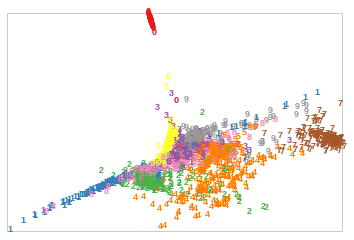

In [43]:
plot_embedding(Z)